In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.backends import cudnn

from torchvision import transforms, models
from movieframe_dataset import MovieFrameDataset
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gc

# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32 --n_samples 1"

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 8

BATCH_SIZE = 16        # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                       # the batch size, learning rate should change by the same factor to have comparable results                    

LR = 1e-3              # The initial Learning Rate
# MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
# WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 5         # Total number of training epochs (iterations over dataset)
# STEP_SIZE = 3        # How many epochs before decreasing learning rate (if using a step-down policy)
# GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 100

In [3]:
# Transforming the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
# Creating the dataset
dataset = MovieFrameDataset(r'D:\\raw_frames\\', r'files\data.tsv', transform=transform, raw=True)

In [5]:
dataset.labels_order

['Action',
 'Adventure',
 'Comedy',
 'Crime',
 'Drama',
 'Horror',
 'Romance',
 'Thriller']

In [6]:
# Creating the data loaders
# train_set, test_set = torch.utils.data.random_split(dataset, [40000, len(dataset)-40000])

indices = np.arange(len(dataset))
indices = np.random.permutation(indices)

subset = Subset(dataset, indices[:5000])

train_set, test_set = torch.utils.data.random_split(subset, [4000, 1000])

print('train_set:', len(train_set))
print('test_set:', len(test_set))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


train_set: 4000
test_set: 1000


D:\\raw_frames\\frames\Drama\eU4-wIieuWU\2806.jpg
D:\\raw_frames\\frames\Drama\yie3IIh0HiQ\506.jpg
D:\\raw_frames\\frames\Drama\bbVqciFRioA\2346.jpg
D:\\raw_frames\\frames\Horror\qqZPej42OkE\966.jpg


c:\Users\krzys\Desktop\Thesis\multiprocessing\movieframe_dataset.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


D:\\raw_frames\\frames\Romance\dDtFWw1mZuw\2576.jpg
D:\\raw_frames\\frames\Drama\LR6C2oVQr_I\2346.jpg
D:\\raw_frames\\frames\Comedy\VD8UttNfU60\966.jpg
D:\\raw_frames\\frames\Adventure_Comedy\-0f67QE-HP8\1656.jpg
D:\\raw_frames\\frames\Comedy_Horror\T5d-R7FDG7s\276.jpg
D:\\raw_frames\\frames\Drama_Romance\XkasRfjEqFs\1426.jpg
D:\\raw_frames\\frames\Comedy\37oJqWp4rJM\46.jpg
D:\\raw_frames\\frames\Comedy_Thriller\1nVThHLqda0\736.jpg
D:\\raw_frames\\frames\Crime_Drama\FD9lsX7gyeo\2346.jpg
D:\\raw_frames\\frames\Action_Thriller\NNfMLLVwiN0\966.jpg
D:\\raw_frames\\frames\Action_Crime\5M4QWD0U8-A\1196.jpg
D:\\raw_frames\\frames\Adventure_Drama\IBeMUoMTeZo\736.jpg
Label: tensor([[0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0.,

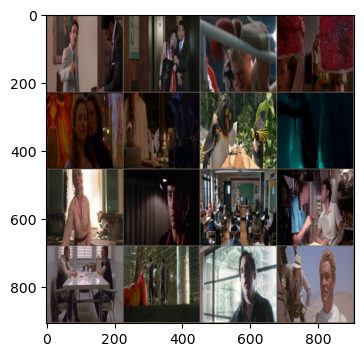

In [7]:
# Displaying the data
for images, labels in train_loader:
    break

# Print the labels
print('Label:', labels)
# print('Category:', *np.array([list(category_names)[i] for i in labels]))

im = make_grid(images, nrow=4)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))


In [6]:
# Choosing the model
# model = models.alexnet(pretrained=True)
# model = models.vgg16(pretrained=True)
# model.classifier[6] = nn.Linear(4096, 8)

def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [7]:
# Choosing the model

class ConvolutionalNetwork(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 64, 3, 1)
        self.fc1 = nn.Linear(26*26*64, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        # print(X.shape)
        X = F.max_pool2d(X, 2, 2)
        # print(X.shape)
        X = F.relu(self.conv2(X))
        # print(X.shape)
        X = F.max_pool2d(X, 2, 2)
        # print(X.shape)
        X = F.relu(self.conv3(X))
        # print(X.shape)
        X = F.max_pool2d(X, 2, 2)
        # print(X.shape)
        X = X.view(-1, 26*26*64)
        # print(X.shape)
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)


In [8]:
model = ConvolutionalNetwork(num_classes=NUM_CLASSES)


# Define loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# By default, everything is loaded to cpu
gpumodel = model.cuda() # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

print(model)
print(count_parameters(model))

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=43264, out_features=8, bias=True)
)
  1728
    64
 73728
   128
 73728
    64
346112
     8
______
495560
None


In [9]:
# Train the model
import time
start_time = time.time()

train_losses = []
test_losses = []
# train_correct = []
# test_correct = []

current_step = 0
test_step = 0

for epoch in range(NUM_EPOCHS):
    torch.cuda.empty_cache()
    gc.collect()
    
    print('Starting epoch {}/{}'.format(epoch+1, NUM_EPOCHS))
    
    # trn_corr = 0
    # tst_corr = 0
    
    # Iterate over the dataset
    for images, labels in train_loader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        gpumodel.train() # Sets module in training mode
        
        optimizer.zero_grad() # Zero-ing the gradients
        
        outputs = gpumodel(images) # Forward pass to the network
        
        # Apply the model
        loss = criterion(outputs, labels)
        
        # # Tally the number of correct predictions
        # predicted = torch.max(outputs.data, 1)[1]
        
        # batch_corr = (predicted == labels).sum()
        # trn_corr += batch_corr
        
        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, loss.item()))
            train_losses.append(loss)

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1
        
    # train_losses.append(loss)
    # train_correct.append(trn_corr)
     
    # Run the testing batches
    for images, labels in test_loader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        gpumodel.train(False) # Sets module in testing mode

        outputs = gpumodel(images) # Forward pass to the network

        # # Tally the number of correct predictions
        # predicted = torch.max(outputs.data, 1)[1] 
        # tst_corr += (predicted == labels).sum()
        
        loss = criterion(outputs, labels)
        
        # Log loss
        if current_step % LOG_FREQUENCY/4 == 0:
            test_losses.append(loss)

    
    test_losses.append(loss)
    # test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Starting epoch 1/5
Step 0, Loss 3.8970956802368164
Step 100, Loss 3.345867156982422
Step 200, Loss 3.486215591430664
Starting epoch 2/5
Step 300, Loss 3.238205671310425
Step 400, Loss 3.3654918670654297


OutOfMemoryError: CUDA out of memory. Tried to allocate 194.00 MiB (GPU 0; 6.00 GiB total capacity; 5.08 GiB already allocated; 0 bytes free; 5.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

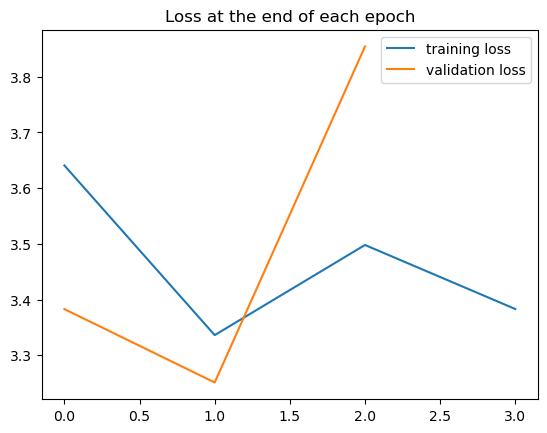

In [ ]:
# Evaluate model performance
train_losses_cpu = [t.cpu().detach().numpy() for t in train_losses]
test_losses_cpu = [t.cpu().detach().numpy() for t in test_losses]

plt.plot(train_losses_cpu, label='training loss')
plt.plot(test_losses_cpu, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

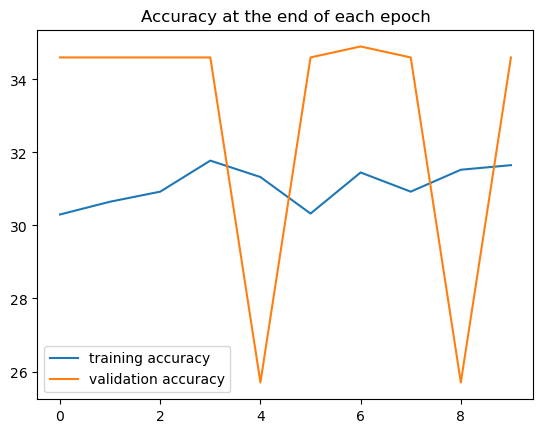

In [ ]:
# train_correct_cpu = [t.cpu().detach().numpy() for t in train_correct]
# test_correct_cpu = [t.cpu().detach().numpy() for t in test_correct]

# plt.plot([t/40 for t in train_correct_cpu], label='training accuracy')
# plt.plot([t/10 for t in test_correct_cpu], label='validation accuracy')
# plt.title('Accuracy at the end of each epoch')
# plt.legend()

In [ ]:
# print(test_correct)
# print(f'Test accuracy: {test_correct[-1].item()*100/1000:.3f}%')

[tensor(346, device='cuda:0'), tensor(346, device='cuda:0'), tensor(346, device='cuda:0'), tensor(346, device='cuda:0'), tensor(257, device='cuda:0'), tensor(346, device='cuda:0'), tensor(349, device='cuda:0'), tensor(346, device='cuda:0'), tensor(257, device='cuda:0'), tensor(346, device='cuda:0')]
Test accuracy: 34.600%


In [ ]:
print('train_losses: ', [t.cpu().detach().numpy().item() for t in train_losses])
# print('train_accuracy: ', [t.cpu().detach().numpy().item()/40 for t in train_correct])
print('test_losses: ', [t.cpu().detach().numpy().item() for t in test_losses])
# print('test_accuracy: ', [t.cpu().detach().numpy().item()/40 for t in test_correct])

train_losses:  [1.6010773181915283, 2.464571475982666, 1.7125465869903564, 1.855602502822876, 1.9534800052642822, 1.7682578563690186, 1.7114670276641846, 2.1305878162384033, 1.7948452234268188, 1.827773094177246]
train_accuracy:  [30.3, 30.65, 30.925, 31.775, 31.325, 30.325, 31.45, 30.925, 31.525, 31.65]
test_losses:  [2.3264033794403076, 2.043823719024658, 2.104731798171997, 2.167724132537842, 2.271791934967041, 2.0800864696502686, 2.179051160812378, 2.150536060333252, 2.185875415802002, 2.132854461669922]
test_accuracy:  [8.65, 8.65, 8.65, 8.65, 6.425, 8.65, 8.725, 8.65, 6.425, 8.65]
